Visualising high dimensional spaces using Bayesian GPLVM
--
*Alexis Boukouvalas, June 2016*

 - Sample from a periodic kernel
 - Visualise the space using Baysian GPLVM

In [30]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12,6)
matplotlib.style.use('ggplot')
%matplotlib inline
import GPflow
import numpy as np
import tensorflow as tf

In [31]:
Q = 2 # latent dimension
D = 5 # true dimension
N = 10
lengthscale = 1.5
variance = 1.3
rng = np.random.RandomState(1)
X_data1 = rng.multivariate_normal(np.zeros(D), 0.1*np.eye(D), N)
X_data2 = rng.multivariate_normal(2*np.ones(D), 1*np.eye(D), N)
X_data  = np.vstack([X_data1,X_data2])
idx = np.vstack([np.ones((N,1)), 2*np.ones((N,1))])
kernel = GPflow.kernels.RBF(Q, variance=variance, lengthscales=lengthscale)

In [32]:
K = kernel.compute_K(X_data, X_data)

L = np.linalg.cholesky(K + np.eye(K.shape[0])*0.01)
Y = L.dot(np.random.randn(L.shape[0],D))

In [33]:
Y.shape

(200, 5)

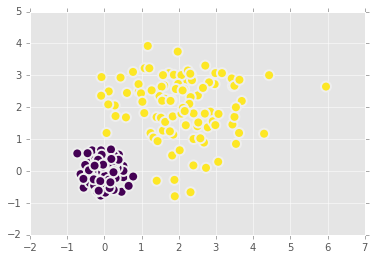

In [34]:
plt.scatter(X_data[:,0], X_data[:,1], 100, idx, lw=2, cmap=plt.cm.viridis)

(200, 2)


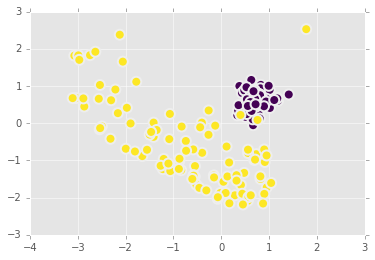

In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components=Q)
Xinit = pca.fit_transform(Y)
print Xinit.shape
plt.scatter(Xinit[:,0], Xinit[:,1], 100, idx, lw=2, cmap=plt.cm.viridis)

(10, 2)
compiling tensorflow function...
done
optimization terminated, setting model state


      fun: array([ 679.23518221])
 hess_inv: <820x820 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.78287995e-04,   3.76196257e-03,  -3.12123635e-03,
        -1.87749365e-03,   5.50596862e-03,  -3.49322180e-03,
         5.86841914e-03,   1.06331475e-02,  -1.46270907e-02,
         2.06577628e-03,  -1.31617475e-03,   1.96944595e-03,
         9.58586100e-03,   9.85163623e-03,  -8.71755200e-03,
        -9.63141846e-03,   4.25453953e-03,   5.57019541e-03,
        -1.15553381e-02,  -7.77597063e-04,  -2.65637350e-04,
         7.08309304e-04,   5.02054829e-03,   1.48852850e-03,
        -2.97882271e-03,  -1.84044590e-03,  -2.52983759e-03,
         2.88190872e-03,  -2.75852761e-03,   3.24185087e-03,
        -1.04541923e-03,   2.17873887e-03,   2.21190183e-03,
        -2.03052391e-03,  -6.06710364e-03,   3.43541598e-03,
        -2.49911808e-03,  -3.02918241e-04,   1.24755445e-03,
        -3.42520007e-04,   2.65754640e-04,  -3.50249221e-03,
         5.71549887e-04,  -4.68378867e-03

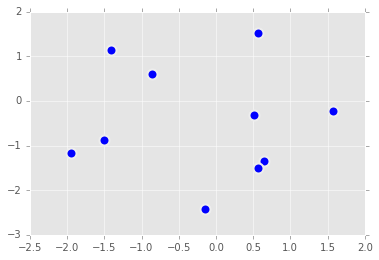

In [36]:
# Bayesian GPLVM model
from GPflow import gplvm

# Create 49 inducings points on a grid
fGrid = False
if(fGrid):
    Z1, Z2 = np.mgrid[X_data.min():X_data.max():7j, X_data.min():X_data.max():7j]
    Z = np.vstack([Z1.ravel(), Z2.ravel()]).T
else:
    Z = rng.multivariate_normal(np.zeros(Q), np.eye(Q), 10)

plt.scatter(Z[:,0], Z[:,1], 100, lw=2, cmap=plt.cm.viridis)

print Z.shape

# just optimize X
kernel.variance.fixed = True
kernel.lengthscales.fixed = True

# m = GPflow.gplvm.BayesianGPLVM(X_mean = np.zeros((2*N,Q)), 
#             X_var=np.ones((2*N,Q)), Y=Y, kern=kernel, Z=Z)

m = GPflow.gplvm.BayesianGPLVM(X_mean = Xinit.copy(),
                X_var=2*np.ones((2*N,Q)), Y=Y, kern=kernel, Z=Z)
m.likelihood.variance = 0.01
m.likelihood.fixed = True
m.X_var = 0.01


m.optimize(max_iters = 500, display=1)

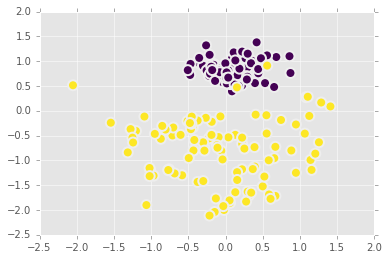

In [37]:
Xinf = m.X_mean.value
plt.scatter(Xinf[:,0], Xinf[:,1], 100, idx, lw=2, cmap=plt.cm.viridis)

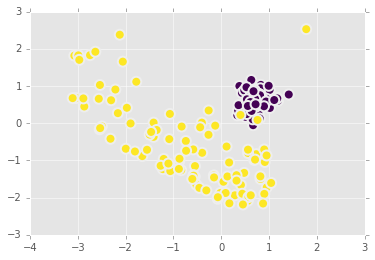

In [38]:
plt.scatter(Xinit[:,0], Xinit[:,1], 100, idx, lw=2, cmap=plt.cm.viridis)

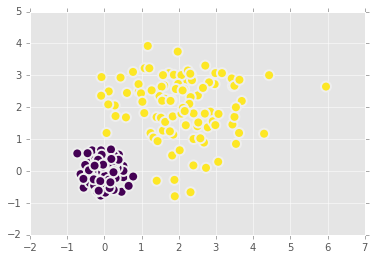

In [39]:
plt.scatter(X_data[:,0], X_data[:,1], 100, idx, lw=2, cmap=plt.cm.viridis)

In [40]:
# Has GPLVM done anything or is it stuck in initialisation?
np.allclose(Xinf,Xinit)

False

In [41]:
print m.X_var

X_var transform:+ve prior:None
[[ 0.00179354  0.00421182]
 [ 0.00490362  0.00257831]
 [ 0.00133203  0.00324102]
 [ 0.00480328  0.00272512]
 [ 0.00352459  0.00290407]
 [ 0.00300445  0.00383777]
 [ 0.00299173  0.00316456]
 [ 0.00236094  0.00282354]
 [ 0.00239439  0.00355933]
 [ 0.00325988  0.00275216]
 [ 0.00210718  0.00397938]
 [ 0.00202641  0.00364881]
 [ 0.00358401  0.00267308]
 [ 0.00329096  0.00301428]
 [ 0.00375265  0.00303578]
 [ 0.00378942  0.00283244]
 [ 0.00289568  0.00325032]
 [ 0.00206994  0.00382823]
 [ 0.00225556  0.00424933]
 [ 0.00246248  0.00366762]
 [ 0.00302229  0.00305646]
 [ 0.00246451  0.00341433]
 [ 0.00722791  0.00220831]
 [ 0.0041092   0.00245324]
 [ 0.0030251   0.00294478]
 [ 0.00143264  0.00367171]
 [ 0.00242647  0.00353414]
 [ 0.00230333  0.00420593]
 [ 0.00202642  0.00347287]
 [ 0.0022032   0.00394094]
 [ 0.00224473  0.00211451]
 [ 0.00263863  0.00398412]
 [ 0.00307431  0.00280992]
 [ 0.00286089  0.00280874]
 [ 0.00339773  0.00292498]
 [ 0.00256421  0.0037261